In [65]:
import numpy as np
import oapackage
import progressbar
import tempfile
import matplotlib.pyplot as plt
try:  # SciPy >= 0.19
    from scipy.special import comb, logsumexp
except ImportError:
    from scipy.misc import comb, logsumexp


folder_path='C:/Users/vipul/Desktop/Orthogonal_array/'
temp_path='C:/Users/vipul/AppData/Local/Temp/'

In [9]:
array=oapackage.exampleArray(2,1)

def array_stats(array):
    print(array)
    array.showarray()
    print('D-efficiency %f, rank %d' % (array.Defficiency(), array.rank()) )
    print('Generalized wordlength pattern: %s' % str(array.GWLP()))
    
array_stats(array)

def array_write(lst):
    filename = tempfile.mktemp('.oa')
    _=oapackage.writearrayfile(filename, lst, oapackage.ATEXT)
    oapackage.oainfo(filename)

def array_read(filename):
    with open(folder_path+filename, 'r') as f:
        matrix = [[int(num) for num in list(line.strip())] for line in f]
    return matrix

lst=array_read('oa_256_16_5_8.txt')
# lst=array_read('oa_64_7_6_1.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

# n,k=np_array.shape
# print(n,k)
# print(list(np_array[2]))

exampleArray 2: array 6 in OA(16, 2, 2^6)
array_link: 16, 6
array:
  0   0   0   0   0   0
  0   0   0   0   0   0
  0   0   0   1   1   1
  0   0   0   1   1   1
  0   1   1   0   0   1
  0   1   1   0   1   0
  0   1   1   1   0   1
  0   1   1   1   1   0
  1   0   1   0   0   1
  1   0   1   0   1   1
  1   0   1   1   0   0
  1   0   1   1   1   0
  1   1   0   0   1   0
  1   1   0   0   1   1
  1   1   0   1   0   0
  1   1   0   1   0   1
D-efficiency 0.000000, rank 6
Generalized wordlength pattern: (1.0, 0.0, 0.0, 2.5, 1.5, 0.0, 0.0)
array_link: 256, 16
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   1   0   0   1   1   0   0   1   1   0   0   1   1   0   0
  1   0   1   0   1   0   1   0   1   0   1   0   1   0   1   0
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  0   1   1   1   1   0   0   0   1   0   0   0   1   0   0   0
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1   0
  0   0   1   1   0   0   1   1   0   0 

In [78]:
# Fitness check

def col_combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

def combination_analysis(comb_count,l):
    combination_count,powt=comb_count.shape
    np_compare=np.full((1,powt),l)
    fail_cols=[]
    fail_combs=[]
    print('Expected output combination: ',np_compare)
    print('Number of column combination: ',combination_count,'    Tuple count (2^t): ',powt)
    for i in range(combination_count):
        if(np.all(comb_count[i] != np_compare)):
            fail_cols.append(i)
            fail_combs.append(list(comb_count[i]))
    if(len(fail_cols)>0):
        print('Minimum tuple value: ', np.amin(comb_count))
        print('Maximum tuple value: ', np.amax(comb_count))
    return fail_cols,fail_combs
        

def fitness_check(np_array,t):
    n,k=np_array.shape
    l=int(n/pow(2,t))
    
    comb_value=comb(k,t)
    comb_count = np.zeros((int(comb_value), pow(2,t)))

    def row_analysis(np_row):
        combinations=col_combinations(list(np_row),t) #All combinations for selection of columns
        np_combinations = np.array(list(combinations))
        combination_index=np_combinations.dot(1 << np.arange(np_combinations.shape[-1] - 1, -1, -1)) #BIN to DEC
        for i in range(0,int(comb_value)):
            index=int(combination_index[i])
            comb_count[i][index]=comb_count[i][index]+1

    print('Number of runs (n):',n)
    print('Number of factors (k):',k)
    print('Strength (t):',t, '     2^t:', pow(2,t)) 
    print("Number of ways for selecting columns: ", comb_value)
    column_combinations=col_combinations(range(k),t)
    np_column_combinations = np.array(list(column_combinations))
    for i in progressbar.progressbar(range(0,n)):
            row_analysis(np_array[i])
            
    print(comb_count)
    
    print('Analysing combination results for l')
#     while l > 0:
    print('Checking for l=',l)
    fail_columns,fail_combinations=combination_analysis(comb_count,l)
    if(len(fail_columns)==0):
        print('PASSED FOR l=',l)
        l=0
    else:
        print('FAILED for l=',l)
        print(len(fail_combinations), 'failed column combinations \n')
        tmp = tempfile.mktemp('.oa')
        tmpfile = open(tmp,"w")
        tmpfile.write('l='+str(l)+' tuple count='+str(pow(2,t)) + '\n')
        tmpfile.write('Column Selection  |  Tupple Counts \n')
        tmpfile.write('[                 ] |')
        for i in range(pow(2,t)):
            tmpfile.write(f'{i:3d}')
        tmpfile.write('\n')
        for i in range(len(fail_combinations)):
            record=str(np_column_combinations[fail_columns[i]])+' |  '+ '  '.join(map(str,map(int,fail_combinations[i])))+'\n'
            tmpfile.write(str(record))
        a = np.array(fail_combinations)
        plt.figure(figsize=(100,100))
        plt.imshow(a, interpolation='nearest')
        plt.show()
        print('saved results to \n',tmp)
        l=l-1
    print('-------------------')


# fitness_check(np_array, 5)

100% (256 of 256) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (163 of 256) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00

array_link: 256, 16
array:
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  1   1   0   0   1   1   0   0   1   1   0   0   1   1   0   0
  1   0   1   0   1   0   1   0   1   0   1   0   1   0   1   0
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  0   1   1   1   1   0   0   0   1   0   0   0   1   0   0   0
  0   1   1   0   0   1   1   0   0   1   1   0   0   1   1   0
  0   0   1   1   0   0   1   1   0   0   1   1   0   0   1   1
  0   1   0   1   0   1   0   1   0   1   0   1   0   1   0   1
  1   0   0   1   1   1   0   0   1   0   1   0   0   0   0   0
  1   1   0   0   1   0   1   0   1   0   0   1   0   0   0   0
  1   0   1   0   1   0   0   1   1   1   0   0   0   0   0   0
  1   0   1   1   0   1   0   0   0   1   0   0   0   1   0   0
  1   1   0   1   0   0   1   0   0   0   1   0   0   0   1   0
  1   0   0   0   0   1   1   1   0   1   1   1   0   1   1   1
  1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0
  1   1   0  

100% (256 of 256) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 23% (59 of 256) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00

[[64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64. 64.]
 [64. 64. 64

100% (256 of 256) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
  7% (20 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02

[[32. 32. 32. ... 32. 32. 32.]
 [32. 32. 32. ... 32. 32. 32.]
 [32. 32. 32. ... 32. 32. 32.]
 ...
 [32. 32. 32. ... 32. 32. 32.]
 [32. 32. 32. ... 32. 32. 32.]
 [32. 32. 32. ... 32. 32. 32.]]
Analysing combination results for l
Checking for l= 32
Expected output combination:  [[32 32 32 32 32 32 32 32]]
Number of column combination:  560     Tuple count (2^t):  8
PASSED FOR l= 32
-------------------
Number of runs (n): 256
Number of factors (k): 16
Strength (t): 4      2^t: 16
Number of ways for selecting columns:  1820.0


100% (256 of 256) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  1% (3 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:08

[[16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]]
Analysing combination results for l
Checking for l= 16
Expected output combination:  [[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]]
Number of column combination:  1820     Tuple count (2^t):  16
PASSED FOR l= 16
-------------------
Number of runs (n): 256
Number of factors (k): 16
Strength (t): 5      2^t: 32
Number of ways for selecting columns:  4368.0


100% (256 of 256) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  1% (3 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]
Analysing combination results for l
Checking for l= 8
Expected output combination:  [[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]]
Number of column combination:  4368     Tuple count (2^t):  32
PASSED FOR l= 8
-------------------
Number of runs (n): 256
Number of factors (k): 16
Strength (t): 6      2^t: 64
Number of ways for selecting columns:  8008.0


100% (256 of 256) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


[[4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 ...
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]]
Analysing combination results for l
Checking for l= 4
Expected output combination:  [[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]]
Number of column combination:  8008     Tuple count (2^t):  64
Minimum tuple value:  2.0
Maximum tuple value:  6.0
FAILED for l= 4
448 failed column combinations 



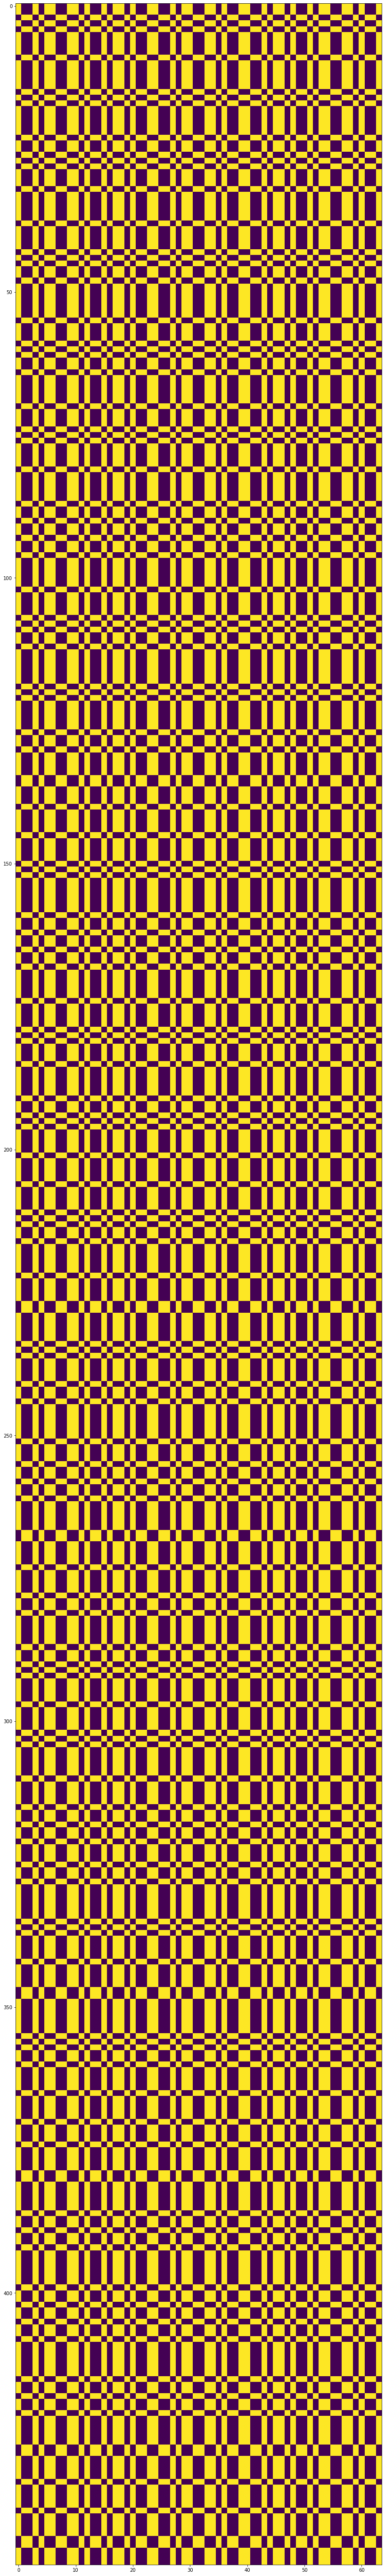

N/A% (0 of 256) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmpmgbyai68.oa
-------------------
Number of runs (n): 256
Number of factors (k): 16
Strength (t): 7      2^t: 128
Number of ways for selecting columns:  11440.0


100% (256 of 256) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
Analysing combination results for l
Checking for l= 2
Expected output combination:  [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
Number of column combination:  11440     Tuple count (2^t):  128
Minimum tuple value:  1.0
Maximum tuple value:  3.0
FAILED for l= 2
4480 failed column combinations 



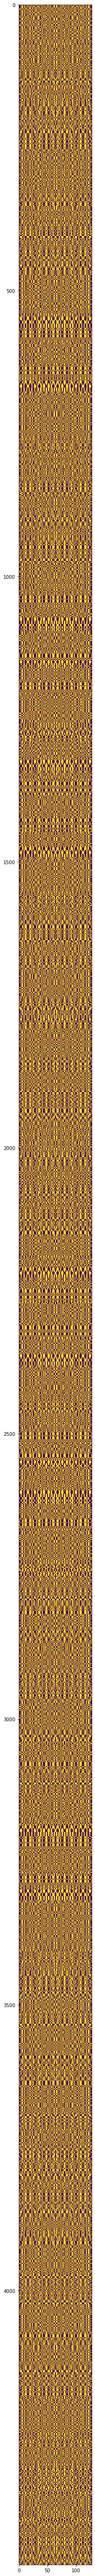

  0% (2 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmpycl5i0gf.oa
-------------------
Number of runs (n): 256
Number of factors (k): 16
Strength (t): 8      2^t: 256
Number of ways for selecting columns:  12870.0


100% (256 of 256) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


[[2. 0. 0. ... 0. 0. 2.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [2. 0. 0. ... 0. 0. 2.]]
Analysing combination results for l
Checking for l= 1
Expected output combination:  [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
Number of column combination:  12870     Tuple count (2^t):  256
Minimum tuple value:  0.0
Maximum tuple value:  2.0
FAILED for l= 1
30 failed column combinations 



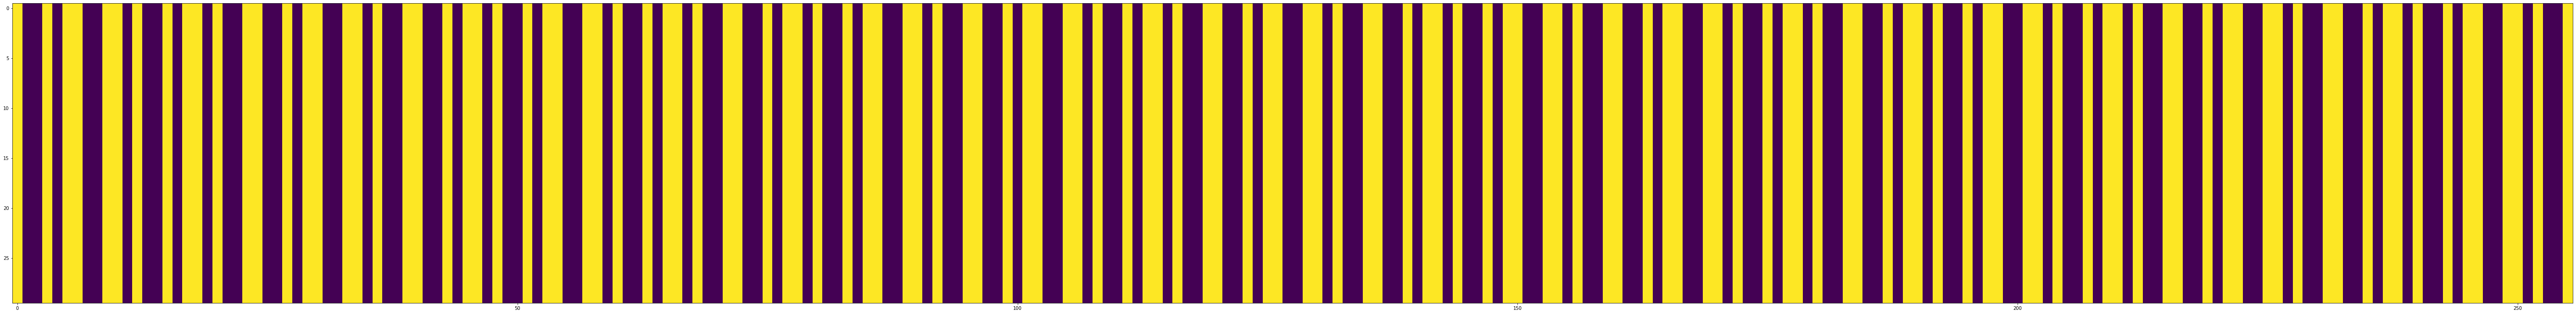

saved results to 
 C:\Users\vipul\AppData\Local\Temp\tmpvugrvri5.oa
-------------------


In [80]:
lst=array_read('oa_256_16_5_8.txt')
# lst=array_read('oa_64_7_6_1.txt')

array=oapackage.array_link(lst)
array_stats(array)
np_array=np.array(array)

fitness_check(np_array, 1)
fitness_check(np_array, 2)
fitness_check(np_array, 3)
fitness_check(np_array, 4)
fitness_check(np_array, 5)
fitness_check(np_array, 6)
fitness_check(np_array, 7)
fitness_check(np_array, 8)




In [ ]:
def creat_oa()
def remove_random(array,)